## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.signal import medfilt
from scipy.optimize import curve_fit

import warnings

## Data Loading

In [11]:
# --- Data Loading ---

def lpr_cor_import(filename):
    """ Import cor file as pandas dataframe."""

    try: 
        df = pd.read_csv(
            filename,
            skiprows=26,
            sep='\s+',
            header=None,
            names=["E", "i", "T"],
        ) 
        df.drop(columns=["T"], inplace=True)
        df.drop(df.head(150).index, inplace=True)
        df["E"] = df["E"]*1e3 # Convert it to mV
        
    except FileNotFoundError as e:
        print(f"Error: File was not found.")
        print(e.message)
        print(e.args)
        return None
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None   
    else:
        return df

In [16]:
HS1_1 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_1.cor")
HS1_2 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_2.cor")
HS1_3 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_3.cor")
HS1_4 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_4.cor")
HS1_5 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_5.cor")
HS1_6 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_6.cor")

# Keep it in the same cell to keep df reproducible, even if Vi clicks it multiple times
area = 2 #cm^2

for df in [HS1_1, HS1_2, HS1_3, HS1_4, HS1_5, HS1_6]:
    df["i"] = np.abs(df["i"]/area) # Current density


In [17]:
HS1_3

E             i
150  -205.474  3.492260e-11
151  -205.464  3.335005e-11
152  -205.454  2.995255e-11
153  -205.444  2.772125e-11
154  -205.434  2.682435e-11
...       ...           ...
3999 -167.010  6.514500e-11
4000 -167.003  6.453200e-11
4001 -167.005  6.450600e-11
4002 -166.991  6.511600e-11
4003 -166.998  6.448450e-11

[3854 rows x 2 columns]

# Coding part!

Separate code into analyze and plotting, with all answers in a dict.
Can't believe it took me this long to really do it this way :|

## Analyze Tafel Data

In [261]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt
import warnings

def analyze_tafel(data: pd.DataFrame) -> dict:
    """
    Analyzes Tafel data to determine electrochemical parameters.

    Args:
        data: DataFrame with 'E' (potential) and 'i' (current) columns.

    Returns:
        A dictionary containing the analysis results.
    """
    INITIAL_KERNEL = 29
    FIT_KERNEL = 99

    # 1. Estimate Corrosion Potential (Ecorr) using a median filter
    ecorr_guess = data['E'].iloc[np.argmin(medfilt(data['i'], kernel_size=INITIAL_KERNEL))]

    # 2. Split data into anodic and cathodic regions based on Ecorr
    anodic_data = data[data['E'] > ecorr_guess + 12].copy()
    cathodic_data = data[data['E'] < ecorr_guess - 12].copy()

    if anodic_data.empty or cathodic_data.empty:
        warnings.warn("No data in anodic or cathodic regions. Ecorr guess may be incorrect.")
        return {}

    anodic_data["i"] = medfilt(anodic_data['i'], kernel_size=FIT_KERNEL)
    cathodic_data["i"] = medfilt(cathodic_data['i'], kernel_size=FIT_KERNEL)

    # 3. Perform linear fit on E vs. log(i) for each branch
    p_anodic = np.poly1d(np.polyfit(    
        np.log10(anodic_data["i"]), 
        anodic_data['E'], 1))
    p_cathodic = np.poly1d(np.polyfit(
        np.log10(cathodic_data["i"]), 
        cathodic_data['E'], 1))
    beta_a = p_anodic[1]
    beta_c = -p_cathodic[1]

    # 3.5 Find the i_corr according to each branch
    # Find the roots of the polynomial p(log(i)) - E_corr = 0
    icorr_anodic = np.power(10, ((p_anodic - ecorr_guess).roots)[0])
    icorr_cathodic = np.power(10,((p_cathodic - ecorr_guess).roots)[0])
    
    # --- 4. Calculations ---
    temp_kelvin = 25.0 + 273.15
    R = 8.314  # Ideal Gas Constant (J/(mol·K))
    F = 96485  # Faraday Constant (C/mol)
    n = 3      # Number of electrons transferred

    alpha_a, alpha_c = None, None
    try:
        # Calculate charge transfer coefficients
        alpha_a = (2.303 * R * temp_kelvin) / (1e-3 * beta_a * n * F)
        alpha_c = (2.303 * R * temp_kelvin) / (1e-3 * beta_c * n * F)
    except ZeroDivisionError as e:
        print(f"Error during calculation: {e}. A slope was zero.")

    return {
        "ecorr_guess": ecorr_guess,
        "p_anodic": p_anodic,
        "p_cathodic": p_cathodic,
        "anodic_data": anodic_data,
        "cathodic_data": cathodic_data,
        "beta_a": beta_a,
        "beta_c": beta_c,
        "alpha_a": alpha_a,
        "alpha_c": alpha_c,
        "icorr_anodic": icorr_anodic,
        "icorr_cathodic": icorr_cathodic,
    }

## Plot Tafel

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import warnings

def plot_tafel(
    data: pd.DataFrame,
    results: dict = None,
    save_path: str = None,
    fig_format: str = 'png',
    column: str = 'single'
):
    """
    Generates a publication-quality Tafel plot from experimental data and analysis results.

    This function formats the plot for single or double-column layouts typical
    in academic journals, including specific font sizes, line styles, and
    LaTeX-formatted labels.

    Args:
        data (pd.DataFrame): The original DataFrame containing experimental data.
                             Must include 'E' (Potential in mV) and 'i' (Current in A).
        results (dict, optional): A dictionary from an analysis function containing keys
                                  like 'ecorr_guess', 'beta_a', 'beta_c', 'p_anodic',
                                  'p_cathodic', 'anodic_data', and 'cathodic_data'.
        save_path (str, optional): The file path to save the figure (without extension).
                                   If None, the plot is displayed instead. Defaults to None.
        fig_format (str, optional): The format to save the figure in (e.g., 'png',
                                    'tiff', 'svg'). Defaults to 'png'.
        column (str, optional): The journal column type for the plot.
                                Can be 'single' or 'double'. Defaults to 'single'.
    """

    # --- 1. Validate Input ---
    if results is None or not isinstance(results, dict):
        warnings.warn(
            "Analysis 'results' dictionary not provided. Plotting experimental data only.",
            UserWarning
        )
        results = {} # Use an empty dict to avoid errors later

    # --- 2. Configure Matplotlib for Publication Quality based on column type ---
    if column == 'single':
        # Parameters for a single-column figure (~3.5 inches wide)
        figsize = (3.5, 3.0)
        plot_params = {
            'font.size': 8,
            'axes.labelsize': 9,
            'legend.fontsize': 7,
            'xtick.labelsize': 7,
            'ytick.labelsize': 7,
            'axes.linewidth': 0.8
        }
        data_line_width = 1.0
        fit_line_width = 1.2
        ecorr_line_width = 0.7
    elif column == 'double':
        # Parameters for a double-column figure (~7 inches wide)
        figsize = (7, 5)
        plot_params = {
            'font.size': 10,
            'axes.labelsize': 11,
            'legend.fontsize': 9,
            'xtick.labelsize': 9,
            'ytick.labelsize': 9,
            'axes.linewidth': 1.0
        }
        data_line_width = 1.2
        fit_line_width = 1.5
        ecorr_line_width = 0.8
    else:
        raise ValueError("Invalid column type specified. Choose 'single' or 'double'.")

    # --- 3. Generate Plot within a temporary style context ---
    with plt.rc_context(rc=plot_params):
        fig, ax = plt.subplots(figsize=figsize, dpi=300)

        # --- 3a. Plot Experimental Data as a Line Plot ---        
        ax.semilogx(
            np.abs(data["i"]),         # x data
            data["E"],                 # y data
            marker='none', 
            linestyle='-',
            color='black',
            linewidth=data_line_width,
            label='Experimental Data'
        )

        # --- 3b. Plot E_corr line and Overpotential Axis ---
        if 'ecorr_guess' in results:
            ecorr = results["ecorr_guess"]
            ax.axhline(
                y=ecorr,
                color='k',
                linestyle='--',
                linewidth=ecorr_line_width,
                alpha=0.8,
                label=f'$E_{{corr}}$ = {ecorr:.1f} mV'
            )

            #ax.set_ylim(top=-160, bottom=-210) 
            #ax.set_xlim(left=10**-16) 
            
            # Create a twin axis for overpotential
            bx = ax.twinx()
            ymin, ymax = ax.get_ylim()
            bx.set_ylim(ymin - ecorr, ymax - ecorr)
            bx.set_ylabel("Overpotential (mV)")

            # Set major ticks to be multiples of 50 mV and add minor ticks
            bx.yaxis.set_major_locator(MultipleLocator(5))
            bx.yaxis.set_minor_locator(AutoMinorLocator(1))

            bx.tick_params(direction='in', which='both')
            bx.spines['right'].set_position(('outward', 0))
        else:
            warnings.warn("Cannot plot E_corr line: 'ecorr_guess' not in results.", UserWarning)

        # --- 3c. Plot Tafel Fit Lines ---
        required_fit_keys = ["anodic_data", "cathodic_data", 
                             'p_anodic', 'p_cathodic', 
                             'icorr_anodic', 'icorr_cathodic',                              
                             'beta_a', 'beta_c']
        if all(key in results for key in required_fit_keys):
            # ANODIC LINE DOTTED
            ax.plot(
                np.logspace(
                    np.log10(results["icorr_anodic"]),
                    np.log10(results["anodic_data"]["i"].max()),
                    100,
                ), 
                results["p_anodic"](
                    np.log10(
                        np.logspace(
                            np.log10(results["icorr_anodic"]),
                            np.log10(results["anodic_data"]["i"].max()),
                            100,  
                        ),
                    )
                ),
                '--', color='#d62728', linewidth=fit_line_width,
                label=f'$\\beta_a$ = {results["beta_a"]:.1f} mV dec$^{{-1}}$ \n $\\alpha_a$ = {results["alpha_a"]:.2f}'
            )
            # ANODIC LINE             
            ax.plot(
                np.logspace(
                    np.log10(results["anodic_data"]["i"].min()),
                    np.log10(results["anodic_data"]["i"].max()),
                    100,
                ), 
                results["p_anodic"](
                    np.log10(               
                        np.logspace(
                            np.log10(results["anodic_data"]["i"].min()),
                            np.log10(results["anodic_data"]["i"].max()),
                            100,
                        ), 
                    )
                ),
                color='#d62728', linewidth=fit_line_width,
            )
            
            # CATHODIC LINE DOTTED
            ax.plot(
                np.logspace(
                    np.log10(results["icorr_cathodic"]),
                    np.log10(results["cathodic_data"]["i"].max()),
                    100,
                ), 
                results["p_cathodic"](
                    np.log10(               
                        np.logspace(
                            np.log10(results["icorr_cathodic"]),
                            np.log10(results["cathodic_data"]["i"].max()),
                            100,
                        ), 
                    )
                ),
                '--', color='#1f77b4', linewidth=fit_line_width,
                label=f'$\\beta_c$ = {results["beta_c"]:.1f} mV dec$^{{-1}}$ \n $\\alpha_c$ = {results["alpha_c"]:.2f}'
            )
            # CATHODIC LINE 
            ax.plot(
                np.logspace(
                    np.log10(results["cathodic_data"]["i"].min()),
                    np.log10(results["cathodic_data"]["i"].max()),
                    100,
                ), 
                results["p_cathodic"](
                    np.log10(               
                        np.logspace(
                            np.log10(results["cathodic_data"]["i"].min()),
                            np.log10(results["cathodic_data"]["i"].max()),
                            100,
                        ), 
                    )
                ),
                color='#1f77b4', linewidth=fit_line_width,
            )

        else:
            warnings.warn("Cannot plot Tafel fit lines: one or more required keys are missing from results.", UserWarning)

        # --- 3d. Configure Plot Aesthetics ---
        ax.set_xlabel('Current Density, |$j$| (A/cm$^2$)')
        ax.set_ylabel('Potential, $E$ vs. Ref. (mV)')
        ax.tick_params(direction='in', which='both', top=True, right=False)
        ax.grid(True, which="both", ls="--", linewidth=0.4, color='gray', alpha=0.6)

        # Combine legends and make the frame less prominent
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(
            lines, labels, loc='best',
            frameon=True,
            framealpha=0.9,
            edgecolor='0.7',
            borderpad=0.3,
            labelspacing=0.4
        )

        fig.tight_layout()

    # --- 4. Finalize and Show/Save Plot ---
    if save_path:
        plt.savefig(f"{save_path}.{fig_format}", format=fig_format, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}.{fig_format}")
    else:
        plt.show()


alpha_a: 0.53
alpha_c: 0.46
Sum of alphas: 0.99


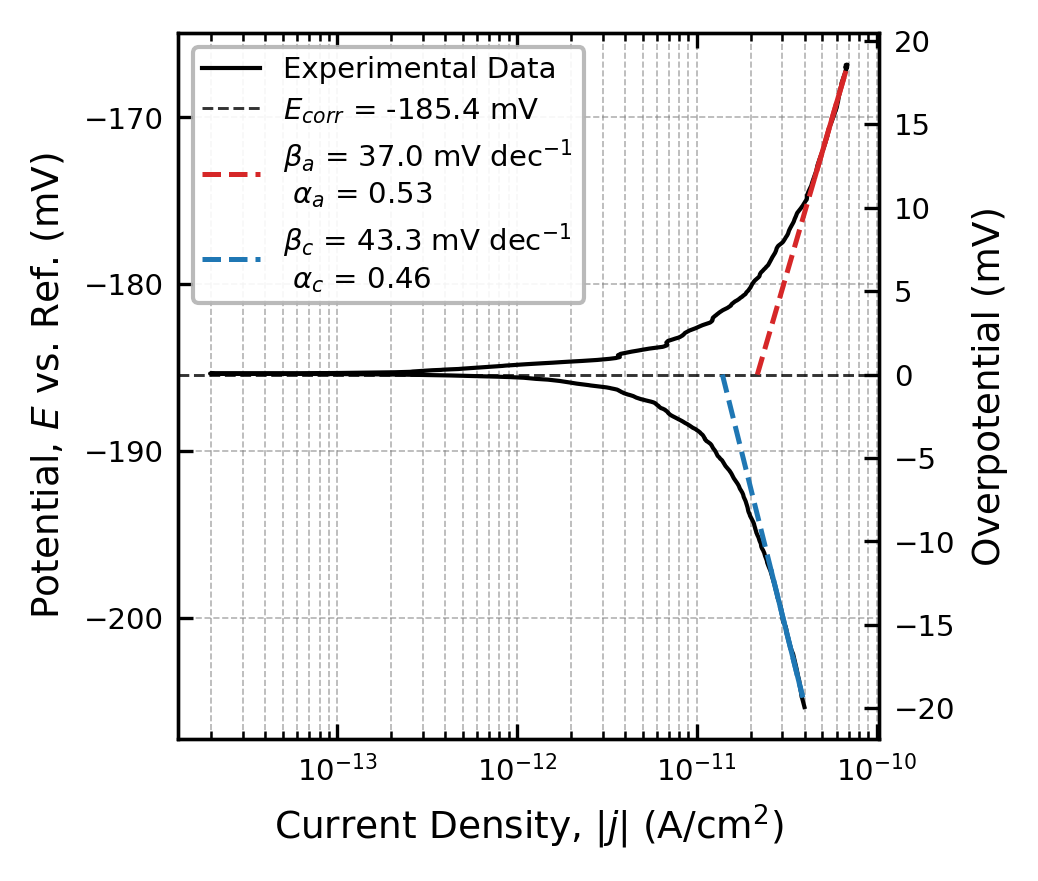

In [265]:
# Assuming 'HS1_6' is your DataFrame loaded with the experimental data
# For example:
# data = {'E': np.linspace(0, 1, 100), 'i': np.logspace(-6, -2, 100)}
# HS1_6 = pd.DataFrame(data)

# 1. Analyze the data
analysis_results = analyze_tafel(HS1_5)

# Print the calculated alpha values
if analysis_results:
    print(f"alpha_a: {analysis_results['alpha_a']:.2f}")
    print(f"alpha_c: {analysis_results['alpha_c']:.2f}")
    if analysis_results['alpha_a'] is not None and analysis_results['alpha_c'] is not None:
        print(f"Sum of alphas: {analysis_results['alpha_a'] + analysis_results['alpha_c']:.2f}")


# 2. Plot the data and the analysis
plot_tafel(HS1_5, analysis_results)

In [255]:
p = analysis_results["p_anodic"] 

In [256]:
p


poly1d([ 31.77354549, 155.49089313])

In [216]:
(2.73)**((p.roots)[0])


np.float64(1.6913954688266906e-11)